In [79]:
from __future__ import annotations

from collections.abc import Iterable
from typing import TYPE_CHECKING, Any, Literal

import polars as pl
import scanpy as sc
from lets_plot import *

import cellestial as cl

LetsPlot.setup_html()
data = sc.read("data/pbmc3k_pped.h5ad")

from lets_plot.plot.core import PlotSpec
from scanpy import AnnData


c:\Users\zafi_\packages\cellestial\.venv\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [80]:
data.var_names

Index(['AL390719.2', 'C1QTNF12', 'AL162741.1', 'LINC01786', 'AL391244.2',
       'TMEM52', 'AL589739.1', 'PLCH2', 'AL513320.1', 'CHD5',
       ...
       'AC244090.3', 'MTCP1', 'TMLHE-AS1', 'AC012078.2', 'PCDH11Y', 'PRKY',
       'KDM5D', 'TTTY10', 'MT-ND2', 'MT-ND5'],
      dtype='object', length=2000)

In [81]:
def dotplot(
    data: AnnData,
    keys: str | list[str] | Iterable[str],
    group_by: str | list[str] | Iterable[str],
    *,
    color_low: str = "#e6e6e6",
    color_high: str = "#D2042D",
    use_raw: bool = True,
    show_tooltips: bool = True,
    add_tooltips: list[str] | tuple[str] | Iterable[str] | None = None,
    custom_tooltips: list[str] | tuple[str] | Iterable[str] | None = None,
    **dotplot_kwargs: dict[str, Any],
) -> PlotSpec:
    # Handling Data types
    if not isinstance(data, AnnData):
        msg = "data must be an `AnnData` object"
        raise TypeError(msg)
    if not isinstance(keys, Iterable) and not isinstance(keys, str):
        msg = "keys must be an iterable or a string"
        raise TypeError(msg)
    elif isinstance(keys, str):
        keys = [keys]
    if not isinstance(group_by, Iterable) and isinstance(group_by, str):
        msg = "group_by must be an iterable or a string"
        raise TypeError(msg)
    elif isinstance(group_by, str):
        group_by = [group_by]

    # handle dotplot_kwargs
    if dotplot_kwargs is None:
        dotplot_kwargs = {}
    else:
        if "tooltips" in dotplot_kwargs:
            msg = "use tooltips args within the function instead of adding `'tooltips' : 'value'` to `dotplot_kwargs`\n"
            raise KeyError(msg)

    # handle tooltips
    base_tooltips = []
    if not show_tooltips:
        tooltips = "none"  # for letsplot, this removes the tooltips
    else:
        if isinstance(custom_tooltips, Iterable):
            tooltips = list(custom_tooltips)
        elif isinstance(add_tooltips, Iterable):
            tooltips = base_tooltips + list(add_tooltips)
        else:
            tooltips = base_tooltips

    if use_raw:
        matrix = data.raw.X.toarray()
    else:
        matrix = data.X

    # gene indexes for the AnnData.X
    gene_indexes = data.var_names.get_indexer(keys)
    frame = pl.from_numpy(matrix[:, gene_indexes], schema=keys)

    for group in group_by:
        frame = frame.with_columns(pl.Series(group, data.obs[group]))

    return frame

In [103]:
keys = ["HBD", "NEAT1", "IGKC"]
groups = ["leiden", "sample"]
gene_indexes = data.var_names.get_indexer(keys)

In [104]:
frame = dotplot(data, keys, groups)
frame

HBD,NEAT1,IGKC,leiden,sample
f32,f32,f32,cat,cat
0.0,0.0,1.0,"""0""","""s1d1"""
0.0,0.0,0.0,"""10""","""s1d1"""
0.0,0.0,0.0,"""15""","""s1d1"""
0.0,0.0,0.0,"""17""","""s1d1"""
0.0,0.0,0.0,"""8""","""s1d1"""
…,…,…,…,…
0.0,0.0,0.0,"""8""","""s1d3"""
0.0,0.0,0.0,"""16""","""s1d3"""
0.0,0.0,0.0,"""5""","""s1d3"""


In [106]:
frameM = frame.unpivot(index=groups, variable_name="gene", value_name="expression")
frameM


leiden,sample,gene,expression
cat,cat,str,f32
"""0""","""s1d1""","""HBD""",0.0
"""10""","""s1d1""","""HBD""",0.0
"""15""","""s1d1""","""HBD""",0.0
"""17""","""s1d1""","""HBD""",0.0
"""8""","""s1d1""","""HBD""",0.0
…,…,…,…
"""8""","""s1d3""","""IGKC""",0.0
"""16""","""s1d3""","""IGKC""",0.0
"""5""","""s1d3""","""IGKC""",0.0


In [112]:
frame.group_by(groups).sum()

leiden,sample,HBD,NEAT1,IGKC
cat,cat,f32,f32,f32
"""17""","""s1d3""",1.0,0.0,33.0
"""1""","""s1d3""",1.0,0.0,34.0
"""8""","""s1d1""",0.0,0.0,13.0
"""16""","""s1d1""",0.0,0.0,81.0
"""14""","""s1d3""",0.0,0.0,48.0
…,…,…,…,…
"""19""","""s1d1""",0.0,0.0,1.0
"""2""","""s1d1""",2.0,0.0,11.0
"""5""","""s1d1""",2.0,0.0,449.0


In [130]:
frame.group_by("sample").mean()

sample,HBD,NEAT1,IGKC,leiden
cat,f32,f32,f32,cat
"""s1d1""",0.001416,0.0,0.221829,null
"""s1d3""",0.001097,0.0,0.223522,null


In [123]:
data.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std
AL390719.2,False,False,False,5,0.000292,0.000292,99.970803,5.0,1.791759,5,True,0.001001,1.840088,1.211725,0.000380,0.024219
C1QTNF12,False,False,False,62,0.003737,0.003730,99.637956,64.0,4.174387,62,True,0.008604,1.871498,1.274180,0.003594,0.069648
AL162741.1,False,False,False,26,0.001518,0.001517,99.848175,26.0,3.295837,26,True,0.003878,1.944082,1.418505,0.001503,0.046608
LINC01786,False,False,False,23,0.001343,0.001342,99.865693,23.0,3.178054,23,True,0.004039,1.990555,1.510911,0.001524,0.047831
AL391244.2,False,False,False,73,0.004438,0.004428,99.573723,76.0,4.343805,73,True,0.008619,1.879800,1.290687,0.003630,0.068932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRKY,False,False,False,2294,0.165139,0.152840,86.604380,2828.0,7.947679,2289,True,0.346883,1.815441,1.162716,0.162510,0.463308
KDM5D,False,False,False,2030,0.140438,0.131412,88.145985,2405.0,7.785721,2028,True,0.283985,1.810605,1.153101,0.131121,0.414425
TTTY10,False,False,False,265,0.016876,0.016735,98.452555,289.0,5.669881,265,True,0.033677,1.812069,1.156013,0.014633,0.137948
MT-ND2,True,False,False,16324,23.342249,3.192214,4.677372,399736.0,12.898562,15951,True,3.988345,4.379118,1.680991,3.313847,1.351333


In [125]:
keys = data.var_names[data.var["highly_variable"]][:10]

In [133]:
list(keys)

['AL390719.2',
 'C1QTNF12',
 'AL162741.1',
 'LINC01786',
 'AL391244.2',
 'TMEM52',
 'AL589739.1',
 'PLCH2',
 'AL513320.1',
 'CHD5']

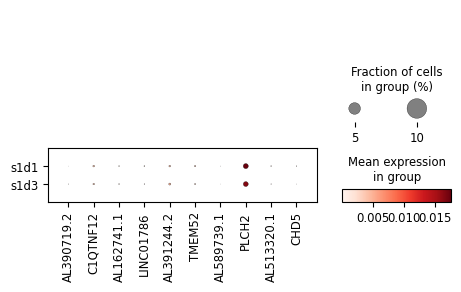

In [127]:
sc.pl.dotplot(data, keys, "sample")

In [136]:
matrix = data.raw.X.toarray()

# gene indexes for the AnnData.X
gene_indexes = data.var_names.get_indexer(keys)
gene_indexes


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [139]:
keys

Index(['AL390719.2', 'C1QTNF12', 'AL162741.1', 'LINC01786', 'AL391244.2',
       'TMEM52', 'AL589739.1', 'PLCH2', 'AL513320.1', 'CHD5'],
      dtype='object')

In [164]:
keys = data.var.sort_values("n_cells_by_counts", ascending=False).head(10).index.to_list()

In [170]:
df

MTRNR2L12,MT-ND5,MT-ND2,HBA1,RPS29,RPL32,RPL30,RPL34,TMSB4X,NEAT1
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
df = pl.from_numpy(matrix[:, gene_indexes], schema=list(keys))
df = df.select(pl.all().sum())
df

MTRNR2L12,MT-ND5,MT-ND2,HBA1,RPS29,RPL32,RPL30,RPL34,TMSB4X,NEAT1
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1.0,0.0,0.0,40.0,3.0,0.0,160.0,7.0,4.0,0.0


In [145]:
df = df.with_columns(
    pl.Series("group", data.obs["sample"]),
)
df

AL390719.2,C1QTNF12,AL162741.1,LINC01786,AL391244.2,TMEM52,AL589739.1,PLCH2,AL513320.1,CHD5,group
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,cat
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""s1d1"""
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""s1d1"""
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""s1d1"""
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""s1d1"""
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""s1d1"""
…,…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""s1d3"""
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""s1d3"""
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""s1d3"""


In [147]:
df.schema

Schema([('AL390719.2', Float32),
        ('C1QTNF12', Float32),
        ('AL162741.1', Float32),
        ('LINC01786', Float32),
        ('AL391244.2', Float32),
        ('TMEM52', Float32),
        ('AL589739.1', Float32),
        ('PLCH2', Float32),
        ('AL513320.1', Float32),
        ('CHD5', Float32),
        ('group', Categorical(ordering='physical'))])

In [146]:
df.group_by("group").count()

C:\Users\zafi_\AppData\Local\Temp\ipykernel_7672\2622976101.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  df.group_by("group").count()


group,count
cat,u32
"""s1d1""",8475
"""s1d3""",8205


In [157]:
df_agg = df.group_by("group").agg(
    [pl.col(col).sum().alias(f"{col}_sum") for col in df.columns if col != "group"]
    + [pl.col(col).mean().alias(f"{col}_mean") for col in df.columns if col != "group"]
    + [pl.col(col).filter(pl.col(col)>1).count().alias(f"{col}_count") for col in df.columns if col != "group"]
)
df_agg

group,AL390719.2_sum,C1QTNF12_sum,AL162741.1_sum,LINC01786_sum,AL391244.2_sum,TMEM52_sum,AL589739.1_sum,PLCH2_sum,AL513320.1_sum,CHD5_sum,AL390719.2_mean,C1QTNF12_mean,AL162741.1_mean,LINC01786_mean,AL391244.2_mean,TMEM52_mean,AL589739.1_mean,PLCH2_mean,AL513320.1_mean,CHD5_mean,AL390719.2_count,C1QTNF12_count,AL162741.1_count,LINC01786_count,AL391244.2_count,TMEM52_count,AL589739.1_count,PLCH2_count,AL513320.1_count,CHD5_count
cat,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""s1d1""",1.0,0.0,0.0,25.0,2.0,0.0,95.0,2.0,1.0,0.0,0.000118,0.0,0.0,0.00295,0.000236,0.0,0.011209,0.000236,0.000118,0.0,0,0,0,0,0,0,2,0,0,0
"""s1d3""",0.0,0.0,0.0,15.0,1.0,0.0,65.0,5.0,3.0,0.0,0.0,0.0,0.0,0.001828,0.000122,0.0,0.007922,0.000609,0.000366,0.0,0,0,0,0,0,0,4,0,1,0
